In [45]:
import torch.cuda
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
import evaluate
import numpy as np
import wandb
import seaborn as sns
from torch import nn
from sklearn.model_selection import StratifiedKFold


with open('secrets/wandb_api_key.txt') as f:
    wandb.login(key=f.read())

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/marcus/.netrc


### Train pre-trained model from hugging face
#### Load Dataset

In [46]:
ds = Dataset.load_from_disk('data/code_search_net_relevance.hf')
ds

Dataset({
    features: ['func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'label', 'text'],
    num_rows: 315
})

#### Convert groups to binary model

In [47]:
def convert_to_binary(data):
    if data['label'] in [2, 3]:
        data['label'] = 1
    return data

ds = ds.map(convert_to_binary)


#### Load tokenizer and preprocess

In [48]:
# PRETRAINED_MODEL = 'distilbert-base-uncased'
PRETRAINED_MODEL = 'microsoft/codebert-base'

In [49]:
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)

def preprocess(data):
    return tokenizer(data['text'], truncation=True, padding=True)

data_tokens = ds.map(preprocess)
data_tokens

Dataset({
    features: ['func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 315
})

In [50]:
# TODO maybe equalize both classes
data_tokens = data_tokens.remove_columns(['func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens'])
data_tokens

Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 315
})

<Axes: xlabel='label', ylabel='count'>

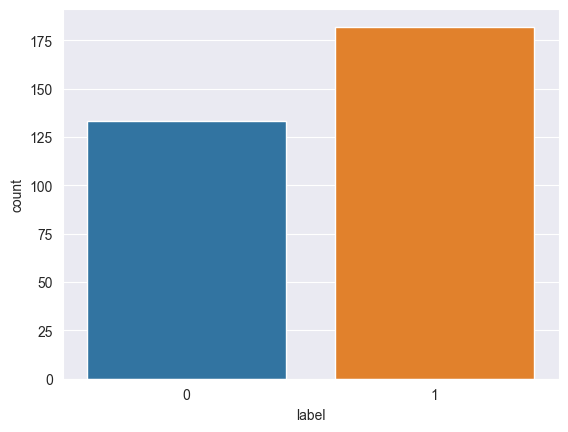

In [51]:
sns.countplot(data_tokens.to_pandas(), x='label')

In [52]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [53]:
tokenizer.decode(data_tokens['input_ids'][0])

'<s>Creates a {@link HtmlPage} from a given {@link String} that contains the HTML code for that page.\n\n@param string {@link String} that contains the HTML code\n@return {@link HtmlPage} for this {@link String}[SEP]public static HtmlPage toHtmlPage(String string) {\n        try {\n            URL url = new URL("http://bitvunit.codescape.de/some_page.html");\n            return HTMLParser.parseHtml(new StringWebResponse(string, url), new WebClient().getCurrentWindow());\n        } catch (IOException e) {\n            throw new RuntimeException("Error creating HtmlPage from String.", e);\n        }\n    }</s>'

#### Evaluate

In [54]:
f1 = evaluate.load('f1')
accuracy = evaluate.load('accuracy')
recall = evaluate.load('recall')
precision = evaluate.load('precision')

In [55]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy_res = accuracy.compute(predictions=predictions, references=labels)
    f1_macro_res = f1.compute(predictions=predictions, references=labels, average='macro')
    f1_micro_res = f1.compute(predictions=predictions, references=labels, average='micro')
    f1_weighted_res = f1.compute(predictions=predictions, references=labels, average='weighted')
    recall_macro_res = recall.compute(predictions=predictions, references=labels, average='macro')
    recall_micro_res = recall.compute(predictions=predictions, references=labels, average='micro')
    recall_weighted_res = recall.compute(predictions=predictions, references=labels, average='weighted')
    precision_macro_res = precision.compute(predictions=predictions, references=labels, average='macro')
    precision_micro_res = precision.compute(predictions=predictions, references=labels, average='micro')
    precision_weighted_res = precision.compute(predictions=predictions, references=labels, average='weighted')

    return {'accuracy': accuracy_res,
            'f1_macro': f1_macro_res, 'f1_micro': f1_micro_res, 'f1_weighted': f1_weighted_res,
            'recall_macro': recall_macro_res, 'recall_micro': recall_micro_res, 'recall_weighted': recall_weighted_res,
            'precision_macro': precision_macro_res, 'precision_micro': precision_micro_res, 'precision_weighted': precision_weighted_res,
            }

#### Split train and test set

In [56]:
train_test = data_tokens.train_test_split(test_size=0.2)

<Axes: xlabel='label', ylabel='count'>

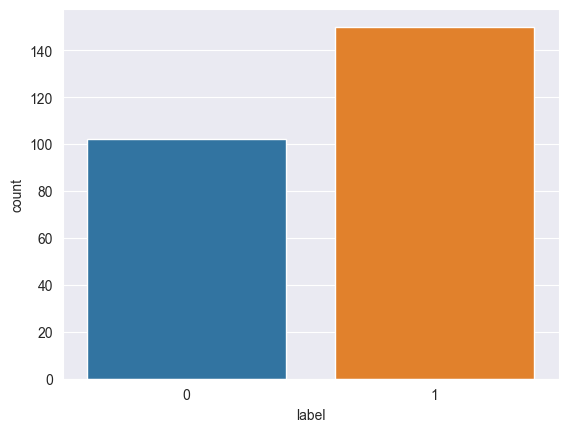

In [57]:
sns.countplot(train_test['train'].to_pandas(), x='label')

<Axes: xlabel='label', ylabel='count'>

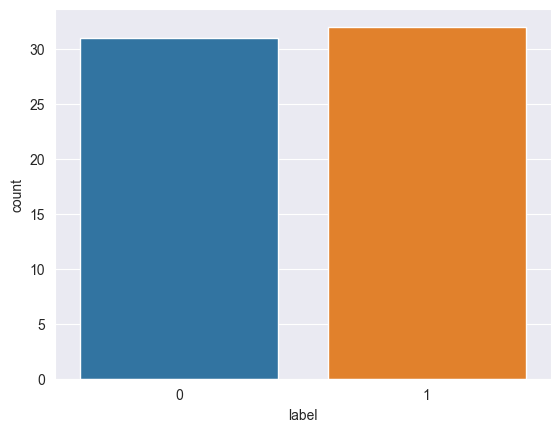

In [58]:
sns.countplot(train_test['test'].to_pandas(), x='label')

#### Train

In [59]:
id2label = {0: 'irrelevant', 1: 'relevant'}
label2id = {'irrelevant': 0, 'relevant': 1}

#### Define custom Trainer to adjust weights for unbalanced classes
Adapted from: https://huggingface.co/docs/transformers/main_classes/trainer

In [60]:
class_count = ds.to_pandas().groupby('label').count()['text'].to_list()
total = sum(class_count)
weights = [1 - (val / total) for val in class_count]
weights

[0.5777777777777777, 0.4222222222222223]

In [61]:


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop('labels')
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weights, device=model.device))
        loss = loss_fn(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

In [62]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = AutoModelForSequenceClassification.from_pretrained(PRETRAINED_MODEL, num_labels=2, id2label=id2label, label2id=label2id)
model.to(device)


training_arguments = TrainingArguments(
    output_dir='m-messer/JavaDoc_Code_Relevance_Classifier',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=5,
    push_to_hub=False,
    report_to=["wandb"]
)



# trainer = Trainer(
#     model=model,
#     args=training_arguments,
#     train_dataset=datasets["train"],
#     eval_dataset=datasets["valid"],
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     compute_metrics=compute_metrics,
# )
#
# trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [66]:
folds = StratifiedKFold(n_splits=10)

splits = folds.split(np.zeros(train_test['train'].num_rows), train_test['train']['label'])

for train_idxs, val_idxs in splits:
    train_data = train_test['train'].select(train_idxs)
    validation_data = train_test['train'].select(val_idxs)

    trainer = CustomTrainer(
        model=model,
        args=training_arguments,
        train_dataset=train_data,
        eval_dataset=validation_data,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()


(array([ 26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
        182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
        195, 196, 197, 198, 199, 200, 201, 202, 203

### Evaluation

In [44]:
model.eval()

evaluator = evaluate.evaluator('text-classification')

eval_results = evaluator.compute(
    model_or_pipeline=model,
    data=train_test['test'],
    label_mapping=label2id,
    tokenizer=tokenizer,
)

eval_results_formatted = {"val/" + key: item for key, item in eval_results.items()}

wandb.log(eval_results_formatted)

NameError: name 'model' is not defined